In [1]:
#!python -m spacy download de_core_news_sm

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator
from torchtext.data.metrics import bleu_score

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import spacy 
import numpy as np 
import time

In [3]:
SEED = 1234
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [4]:
spacy_en = spacy.load('en_core_web_sm')
spacy_de = spacy.load('de_core_news_sm')

def tokenize_de(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]

def tokenize_en(text):
    return [tok.text for tok in spacy_de.tokenizer(text)]

In [5]:
SRC = Field(tokenize = tokenize_en,
            init_token='<sos>',
            eos_token='<eos>',
            lower=True)

TRG = Field(tokenize=tokenize_de,
            init_token='<sos>',
            eos_token='<eos>',
            lower=True)

In [6]:
train_data, valid_data, test_data = Multi30k.splits(exts=('.en', '.de'), fields=(SRC, TRG))

In [7]:
BATCH_SIZE = 128
SRC.build_vocab(train_data, min_freq=2)
TRG.build_vocab(train_data, min_freq=2)

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size=BATCH_SIZE, device='cuda'
)


In [15]:
class Encoder(nn.Module):
  def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
    super().__init__()
    self.embedding = nn.Embedding(input_dim, emb_dim)
    self.dropout = nn.Dropout(dropout)
    self.rnn = nn.GRU(emb_dim, enc_hid_dim, bidirectional=True)
    self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim, bias=False)

  def forward(self, src):
    # src : [src_len, batch_size]
    embed = self.dropout(self.embedding(src))
    # embed : [src_len, batch_size, emb_dim]
    output, hidden = self.rnn(embed)
    # output : [src_len, batch_size, hidden_dim * num_directions]
    # hidden : [num_directions * num_layers, batch_size, enc_hid_dim  ]
    hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))) # concatenate along the row dimension
    # hidden  : [batch_size, dec_hid_dim]
    return output, hidden


class Attention(nn.Module):
  def __init__(self, enc_hid_dim, dec_hid_dim):
    super().__init__()
    self.attn = nn.Linear(2 * enc_hid_dim + dec_hid_dim, dec_hid_dim)
    self.v = nn.Linear(dec_hid_dim, 1, bias=False)

  def forward(self, dec_hidden, encoder_outputs):
    # encoder_outputs : [src_len, batch_size, hidden_dim * num_directions]
    # dec_hidden : [batch_size, dec_hid_dim]
    src_len = encoder_outputs.shape[0]

    dec_hidden = dec_hidden.unsqueeze(1).repeat(1, src_len, 1)
    # dec_hidden = [batch_size, src_len, dec_hid_dim]
    encoder_outputs = encoder_outputs.permute(1,0,2)
    # encoder_outputs : [batch_size, src_len, hidden_dim * num_directions]

    energy = torch.tanh(self.attn(torch.cat((dec_hidden, encoder_outputs), dim=2)))
    # energy : [batch_size, src_len, dec_hid_dim]
    attention = self.v(energy).squeeze(2)
    # attention : [batch_size, src_len]
    return F.softmax(attention, dim=1)


class Decoder(nn.Module):
  def __init__(self, output_dim, emb_dim, enc_hid_dim,dec_hid_dim, dropout, attention):
    super().__init__()
    self.embedding = nn.Embedding(output_dim, emb_dim)
    self.output_dim = output_dim
    self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
    self.fc_out = nn.Linear(2 * enc_hid_dim + emb_dim + dec_hid_dim, output_dim )
    self.dropout = nn.Dropout(dropout)
    self.attention = attention
  
  def forward(self, inp, hidden, encoder_outputs):
    # inp : [batch_size]
    inp = inp.unsqueeze(0)
    # inp : [1, batch_size] 
    embedding = self.dropout(self.embedding(inp))
    # embedding : [1, batch_size, emb_dim]
    a = self.attention(hidden, encoder_outputs).unsqueeze(1)
    # a : [batch_size,1, src_len]

    encoder_outputs = encoder_outputs.permute(1, 0, 2)
    # enc_outputs : [batch_size, src_len, enc_hid_dim * 2]

    weighted = torch.bmm(a, encoder_outputs) # get the encoder outputs weighed by the corresponding attention weights
    # weighted : [ batch_size, 1, enc_hid_dim * 2]
    weighted = weighted.permute(1, 0, 2)

    # weighted : [1, batch_size, enc_hid_dim * 2]
    rnn_input = torch.cat((embedding, weighted), dim =2)
    # rnn_input : [1, batch_size, enc_hid_dim * 2 + emb_hid]

    output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
    #output : [1, batch_size, dec_hid_dim]
    #hidden : [1, batch_size, dec_hid_dim]
    embedding = embedding.squeeze(0)
    output = output.squeeze(0)
    weighted = weighted.squeeze(0)

    prediction = self.fc_out(torch.cat((output, weighted, embedding), dim=1))

    # prediction : [batch_size, output_dim]
    return prediction, hidden.squeeze(0), a.squeeze(1)

In [16]:
class Seq2Seq(nn.Module):
  def __init__(self, encoder, decoder, device):
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder
    self.device = device
    
  def forward(self,src, trg, teacher_forcing_ratio=0.5):
    #src : [src_len, batch_size]
    #trg : [src_len, batch_size]

    batch_size = src.shape[1]
    trg_len = trg.shape[0]
    trg_vocab_size = self.decoder.output_dim

    outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
    encoder_outputs, hidden = self.encoder(src)
    inp = trg[0, :]

    for t in range(1, trg_len):
      output, hidden, _ = self.decoder(inp, hidden, encoder_outputs)
      # output: [batch_size, output_dim]
      # hidden: [batch_size, dec_hid_dim]

      outputs[t] = output

      teacher_force = np.random.random() < teacher_forcing_ratio 

      top1 = output.argmax(1) 
      inp = trg[t] if teacher_force else top1

    return outputs





In [17]:
device='cuda'
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 128
DEC_EMB_DIM = 128
ENC_HID_DIM = 256
DEC_HID_DIM = 256
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]

attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, device).to(device)

In [18]:
def init_weights(m):
  for name, param in m.named_parameters():
    if 'weight' in name:
      nn.init.normal_(param.data, mean=0, std=0.01)
    else:
      nn.init.constant_(param.data, 0)

model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(5923, 128)
    (dropout): Dropout(p=0.5, inplace=False)
    (rnn): GRU(128, 256, bidirectional=True)
    (fc): Linear(in_features=512, out_features=256, bias=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(7873, 128)
    (rnn): GRU(640, 256)
    (fc_out): Linear(in_features=896, out_features=7873, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
    (attention): Attention(
      (attn): Linear(in_features=768, out_features=256, bias=True)
      (v): Linear(in_features=256, out_features=1, bias=False)
    )
  )
)

In [19]:
optimizer = optim.Adam(model.parameters())
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]
criterion = nn.CrossEntropyLoss(ignore_index=TRG_PAD_IDX)

def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing
            
            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [20]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [21]:
N_EPOCHS = 20
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        #torch.save(model.state_dict(), 'tut4-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {np.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {np.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 0m 52s
	Train Loss: 5.346 | Train PPL: 209.856
	 Val. Loss: 5.093 |  Val. PPL: 162.947
Epoch: 02 | Time: 0m 52s
	Train Loss: 4.423 | Train PPL:  83.355
	 Val. Loss: 5.040 |  Val. PPL: 154.520
Epoch: 03 | Time: 0m 52s
	Train Loss: 4.070 | Train PPL:  58.561
	 Val. Loss: 4.520 |  Val. PPL:  91.820
Epoch: 04 | Time: 0m 53s
	Train Loss: 3.699 | Train PPL:  40.396
	 Val. Loss: 4.078 |  Val. PPL:  59.019
Epoch: 05 | Time: 0m 53s
	Train Loss: 3.312 | Train PPL:  27.436
	 Val. Loss: 3.688 |  Val. PPL:  39.979
Epoch: 06 | Time: 0m 53s
	Train Loss: 2.952 | Train PPL:  19.136
	 Val. Loss: 3.508 |  Val. PPL:  33.376
Epoch: 07 | Time: 0m 53s
	Train Loss: 2.675 | Train PPL:  14.507
	 Val. Loss: 3.377 |  Val. PPL:  29.290
Epoch: 08 | Time: 0m 53s
	Train Loss: 2.432 | Train PPL:  11.377
	 Val. Loss: 3.288 |  Val. PPL:  26.781
Epoch: 09 | Time: 0m 53s
	Train Loss: 2.240 | Train PPL:   9.389
	 Val. Loss: 3.256 |  Val. PPL:  25.944
Epoch: 10 | Time: 0m 53s
	Train Loss: 2.051 | Train PPL

In [25]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):

    model.eval()
        
    if isinstance(sentence, str):
        nlp = spacy.load('de')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(1).to(device)
    # src_tensor : [1, len(tokens)]

    src_len = torch.LongTensor([len(src_indexes)]).to(device)
    with torch.no_grad():
        encoder_outputs, hidden = model.encoder(src_tensor)
    # encoder_outputs : [src_len, 1, dec_hid_dim]
    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    attentions = torch.zeros(max_len, 1, len(src_indexes)).to(device)
    # attentions : [max_len,1,len(tokens)]
    for i in range(max_len):

        trg_tensor = torch.LongTensor([trg_indexes[-1]]).to(device)
                
        with torch.no_grad():
            output, hidden, attention = model.decoder(trg_tensor, hidden, encoder_outputs)

        attentions[i] = attention
            
        pred_token = output.argmax(1).item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attentions[:len(trg_tokens)-1]

In [26]:
def display_attention(sentence, translation, attention):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    attention = attention.squeeze(1).cpu().detach().numpy()
    
    cax = ax.matshow(attention, cmap='bone')
   
    ax.tick_params(labelsize=15)
    ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                       rotation=45)
    ax.set_yticklabels(['']+translation)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

In [29]:
example_idx = 12

src = vars(valid_data.examples[example_idx])['src']
trg = vars(valid_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

src = ['three', 'young', 'children', 'stand', 'around', 'a', 'blue', 'and', 'white', 'barrel', '.']
trg = ['drei', 'kleine', 'kinder', 'stehen', 'um', 'ein', 'blau', '-', 'weißes', 'fass', 'herum', '.']
predicted trg = ['drei', 'kleine', 'kinder', 'stehen', 'um', 'blau', '-', 'weiße', 'herum', '.', '<eos>']


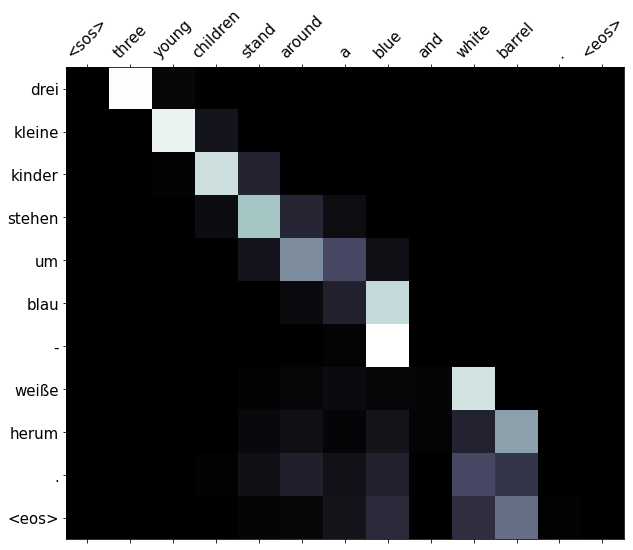

In [32]:

display_attention(src, translation, attention)

In [33]:

def calculate_bleu(data, src_field, trg_field, model, device, max_len=50):
  trgs=[]
  pred_trgs=[]

  for d in data:
    src = vars(d)['src']
    trg = vars(d)['trg']

    pred_trg, _ = translate_sentence(src, src_field, trg_field, model, 'cuda')

    pred_trg = pred_trg[:-1]
    pred_trgs.append(pred_trg)
    trgs.append([trg])

  return bleu_score(pred_trgs, trgs)

In [36]:
bleu_score = calculate_bleu(test_data, SRC, TRG, model, device)
print(f'bleu_score : {bleu_score * 100}')

bleu_score : 29.15014922618866
